In [1]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [2]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [40]:
review = pd.read_csv(r'/content/IMDB Dataset.csv')

In [41]:
review.head()

,Id,review,sentiment
0,1,One of the other reviewers has mentioned that ...,positive
1,2,A wonderful little production. <br /><br />The...,positive
2,3,I thought this was a wonderful way to spend ti...,positive
3,4,Basically there's a family where a little boy ...,negative
4,5,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [42]:
review.isnull().sum()

,0
Id,0
review,0
sentiment,0


In [44]:
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [45]:
df = review.drop_duplicates(subset="review").reset_index(drop=True)

In [46]:
df["cleaned_review"] = df["review"].apply(clean_text)

# Inspect cleaned data
print(df.head())

<ipython-input-44-b4865c33787a>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


   Id                                             review sentiment  \
0   1  One of the other reviewers has mentioned that ...  positive   
1   2  A wonderful little production. <br /><br />The...  positive   
2   3  I thought this was a wonderful way to spend ti...  positive   
3   4  Basically there's a family where a little boy ...  negative   
4   5  Petter Mattei's "Love in the Time of Money" is...  positive   

                                      cleaned_review  
0  one of the other reviewers has mentioned that ...  
1  a wonderful little production the filming tech...  
2  i thought this was a wonderful way to spend ti...  
3  basically theres a family where a little boy j...  
4  petter matteis love in the time of money is a ...  


In [47]:
from nltk.corpus import stopwords
import nltk

# Download stopwords once
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df["cleaned_review"] = df["cleaned_review"].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [48]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["cleaned_review"] = df["cleaned_review"].apply(stem_text)


In [49]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
nltk.download("wordnet")

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["cleaned_review"] = df["cleaned_review"].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [53]:
print(df.head())

   Id                                             review sentiment  \
0   1  One of the other reviewers has mentioned that ...  positive   
1   2  A wonderful little production. <br /><br />The...  positive   
2   3  I thought this was a wonderful way to spend ti...  positive   
3   4  Basically there's a family where a little boy ...  negative   
4   5  Petter Mattei's "Love in the Time of Money" is...  positive   

                                      cleaned_review  review_length  
0  one review mention watch 1 oz episod youll hoo...            168  
1  wonder littl product film techniqu unassum old...             84  
2  thought wonder way spend time hot summer weeke...             86  
3  basic there famili littl boy jake think there ...             67  
4  petter mattei love time money visual stun film...            125  


<ipython-input-54-f33f680c0d72>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df, palette="Set2")


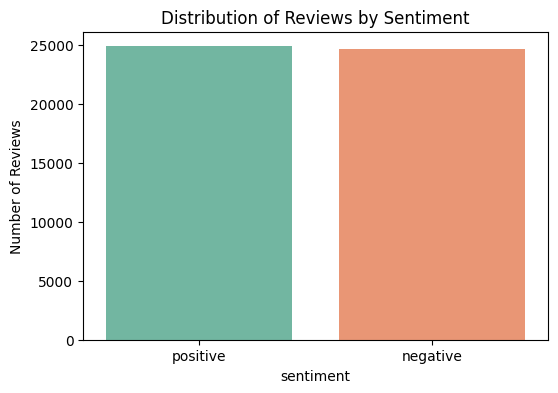

In [54]:
sentiment_counts = df["sentiment"].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="sentiment", data=df, palette="Set2")
plt.title("Distribution of Reviews by Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

In [55]:
df["review_length"] = df["cleaned_review"].apply(lambda x: len(x.split()))
avg_review_length = df.groupby("sentiment")["review_length"].mean()

print(f"Average Review Length (Positive vs Negative):\n{avg_review_length}")

Average Review Length (Positive vs Negative):
sentiment
negative    118.55547
positive    121.23497
Name: review_length, dtype: float64


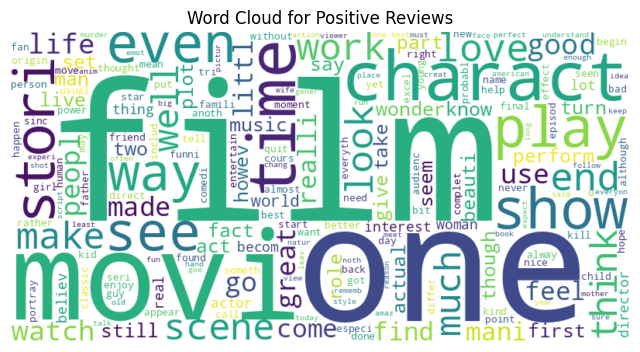

In [56]:
from wordcloud import WordCloud


positive_reviews = df[df["sentiment"] == "positive"]["cleaned_review"].str.cat(sep=" ")
wordcloud_positive = WordCloud(width=800, height=400, background_color="white").generate(positive_reviews)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.title("Word Cloud for Positive Reviews")
plt.axis("off")
plt.show()



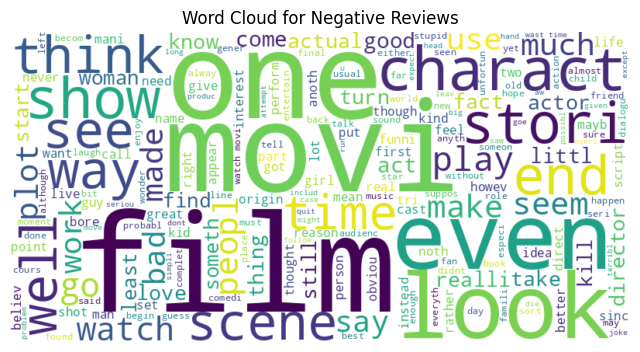

In [57]:
negative_reviews = df[df["sentiment"] == "negative"]["cleaned_review"].str.cat(sep=" ")
wordcloud_negative = WordCloud(width=800, height=400, background_color="white").generate(negative_reviews)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.title("Word Cloud for Negative Reviews")
plt.axis("off")
plt.show()

<ipython-input-58-298037100d21>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sentiment", y="review_length", data=df, palette="Set2")


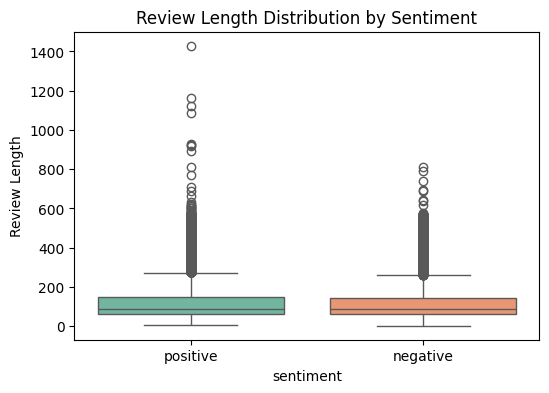

In [58]:
# Review Length Distribution
plt.figure(figsize=(6, 4))
sns.boxplot(x="sentiment", y="review_length", data=df, palette="Set2")
plt.title("Review Length Distribution by Sentiment")
plt.ylabel("Review Length")
plt.show()


In [59]:
#Baseline: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review']).toarray()
y = df['sentiment'].map({'positive': 1, 'negative': 0})


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [62]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [63]:
y_val_pred = model.predict(X_val)
print("Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(classification_report(y_val, y_val_pred))

Validation Metrics:
Accuracy: 0.8806
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3952
           1       0.87      0.89      0.88      3981

    accuracy                           0.88      7933
   macro avg       0.88      0.88      0.88      7933
weighted avg       0.88      0.88      0.88      7933



In [64]:
y_test_pred = model.predict(X_test)
print("Test Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred))

Test Metrics:
Accuracy: 0.8835
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4940
           1       0.87      0.90      0.89      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



In [27]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch


dataset = Dataset.from_pandas(df)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict(data)
val_dataset = Dataset.from_dict(data)
test_dataset = Dataset.from_dict(data)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True, max_length=128)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Load BERT model for classification
num_classes = 2  # Binary classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Set up the TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate(test_dataset)

# Print the evaluation results
print("Test Results:", results)

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-27-ea0b057a2ef9>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.726039
2,No log,0.724635
3,No log,0.722086


Test Results: {'eval_loss': 0.7220863103866577, 'eval_runtime': 1.515, 'eval_samples_per_second': 2.64, 'eval_steps_per_second': 0.66, 'epoch': 3.0}


In [71]:
# Save the model and vectorizer
import joblib
joblib.dump(model, "sentiment_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
print("Model and vectorizer saved.")

Model and vectorizer saved.


In [72]:
# Load the trained model and vectorizer
model = joblib.load('sentiment_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

In [ ]:
from flask import Flask, request, jsonify
import joblib
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Initialize Flask app
app = Flask(__name__)

# Load the trained model and vectorizer
model = joblib.load('sentiment_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')
# Define the prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    try:

        data = request.get_json()
        review_text = data['review_text']


        review_vector = vectorizer.transform([review_text])


        prediction = model.predict(review_vector)

        sentiment = "positive" if prediction[0] == 1 else "negative"
        return jsonify({'sentiment_prediction': sentiment})

    except Exception as e:
        return jsonify({'error': str(e)}), 400

# Run the app
if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
